In [2]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale, StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

from sklearn import linear_model
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, mean_squared_error, r2_score, roc_auc_score, roc_curve

#import shap
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image

In [3]:
import os
print(os.getcwd())

C:\Users\amirf


In [4]:
hospital_table_naive = pd.read_excel(r"C:\Users\amirf\Downloads\corona_hospitalization.xlsx")
hospital_table_naive.head()

,Date,hospitalized,% hospitalized women,avg age hospitalized,SD age hospitalized,respirated,% women on a respirator,avg age on a respirator,SD age on a respirator,% unvaccinated on a respirator,...,% women moderate sick,unvaccinated moderate sick,avg age moderate sick,sd age moderate sick,critical sick,% critical sick women,% unvaccinated critical sick,avg age critical sick,sd age critical sick,sum over time of critical sick
0,2020-03-11,79,45.6,47.8,18.1,<15,40.0,63.8,15.3,100.0,...,NaN,NaN,NaN,NaN,<15,50.0,100.0,67.3,16.2,<15
1,2020-03-12,102,49.0,49.9,18.2,<15,40.0,63.8,15.3,100.0,...,NaN,NaN,NaN,NaN,<15,50.0,100.0,67.3,16.2,<15
2,2020-03-13,120,47.5,49.2,18.4,<15,40.0,63.8,15.3,100.0,...,40.0,100.0,68.0,16.7,<15,50.0,100.0,67.3,16.2,<15
3,2020-03-14,158,49.4,47.4,18.5,<15,NaN,70.3,7.4,100.0,...,40.0,100.0,68.0,16.7,<15,20.0,100.0,76.8,10.3,<15
4,2020-03-15,197,51.8,46.5,18.7,<15,20.0,74.0,7.6,100.0,...,50.0,100.0,61.3,17.5,<15,37.5,100.0,79.0,9.1,<15


In [5]:
hospital_table_naive_2=hospital_table_naive.fillna(0)
#hospital_table_naive_2.info()

In [6]:
# Function to convert "<15" to a random integer between 0 and 14

# the 1st function option is for just random numbers between 0-14. we won't use it.
#def convert_less_than_15(value):
 #   if value == "<15":
 #       return np.random.randint(0, 15)  # Generates a random integer from 0 to 14
  #  return value  # In case there are other values, return them unchanged

# the 2nd function is for  random numbers between 0-14 in a NORMAL distribution, which we prefer for this data.
def convert_less_than_15(value):
    if value == "<15":
        mean = 7  # change mean if needed
        std_dev = 3  # change standard deviation if needed
        # Generate a random number from a normal distribution
        random_value = int(np.random.normal(mean, std_dev))
        # Ensure the value is within the desired range (0 to 14)
        return max(0, min(14, random_value))
    return value  # Return other values unchanged


# Apply the function to the 'respirated' column
hospital_table_naive_2['respirated'] = hospital_table_naive_2['respirated'].apply(convert_less_than_15)

# Apply the function to the 'moderate sick' column
hospital_table_naive_2['moderate sick'] = hospital_table_naive_2['moderate sick'].apply(convert_less_than_15)

# Apply the function to the 'critical sick' column
hospital_table_naive_2['critical sick'] = hospital_table_naive_2['critical sick'].apply(convert_less_than_15)




# Display the DataFrame
hospital_table_naive_2["respirated"].head(20)
#print(new_table)


# Display the DataFrame

hospital_table_naive_2.loc[:,['respirated', 'moderate sick', 'critical sick', 'sum over time of critical sick']].head(2)
#print(hospital_table_2)
#hospital_table_2.loc[:,['respirated', 'moderate sick', 'critical sick', 'sum over time of critical sick']].tail(50)

,respirated,moderate sick,critical sick,sum over time of critical sick
0,14,0,4,<15
1,1,0,7,<15


In [7]:
# Update the column "% unvaccinated on a respirator" for the year 2020
hospital_table_naive_2.loc[hospital_table_naive_2.Date == 2020, '% unvaccinated on a respirator'] = 100

In [8]:
# turn object type columns into float type
hospital_table_naive_2['respirated'] = hospital_table_naive_2['respirated'].astype(float)
hospital_table_naive_2['mild sick'] = hospital_table_naive_2['mild sick'].astype(float)
hospital_table_naive_2['moderate sick'] = hospital_table_naive_2['moderate sick'].astype(float)
hospital_table_naive_2['critical sick'] = hospital_table_naive_2['critical sick'].astype(float)

In [9]:
# Creating a new df without some of the columns

#hospital_table_3 = hospital_table_2.filter(['hospitalized','mild sick','moderate sick'])
hospital_table_naive_3 = hospital_table_naive_2.drop(['SD age hospitalized','SD age on a respirator','sd mild sick', 'sum over time of critical sick', 'sd age critical sick', 'sd age moderate sick'], axis=1)


print(hospital_table_naive_3.dtypes)  # To check the data types

Date                              datetime64[ns]
hospitalized                               int64
% hospitalized women                     float64
avg age hospitalized                     float64
respirated                               float64
% women on a respirator                  float64
avg age on a respirator                  float64
% unvaccinated on a respirator           float64
mild sick                                float64
%mild sick women                         float64
% mild sick unvaccinated                 float64
avg mild sick                            float64
moderate sick                            float64
% women moderate sick                    float64
unvaccinated moderate sick               float64
avg age moderate sick                    float64
critical sick                            float64
% critical sick women                    float64
% unvaccinated critical sick             float64
avg age critical sick                    float64
dtype: object


In [12]:
# Creating a new df without some of the columns

hospital_table_naive_4 = hospital_table_naive_3.filter(['Date','respirated'])
hospital_table_naive_4.head()


,Date,respirated
0,2020-03-11,14.0
1,2020-03-12,1.0
2,2020-03-13,6.0
3,2020-03-14,2.0
4,2020-03-15,7.0


In [13]:
#hospital_table_naive_3.to_csv('hospital_table_3.csv')

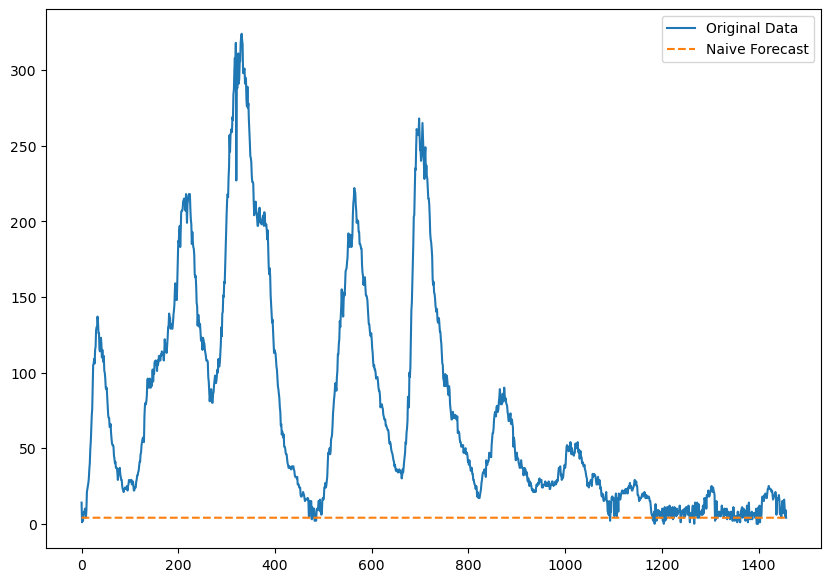

In [14]:
# simple naive model

import pandas as pd
import matplotlib.pyplot as plt

# Assume 'df' is your DataFrame with the time series data
# and 'value' is the column containing the time series values

# Get the last observed value
last_observed_value = hospital_table_naive_4['respirated'].iloc[-1]

# Predict the next value
naive_forecast = [last_observed_value] * len(hospital_table_naive_4)

# Plot the original data and the naive forecast
plt.figure(figsize=(10, 7))
plt.plot(hospital_table_naive_4['respirated'], label='Original Data')
plt.plot(naive_forecast, label='Naive Forecast', linestyle='--')
plt.legend()
plt.show()

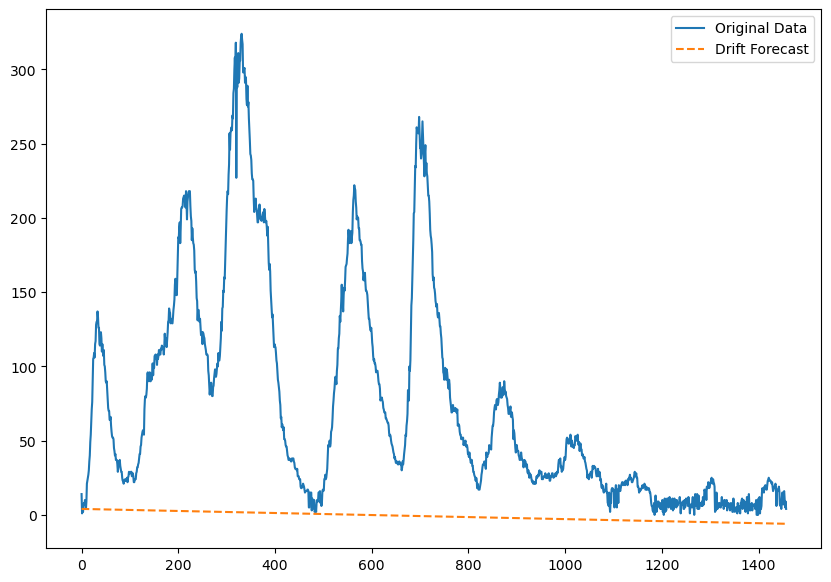

In [15]:
# drift method:

import pandas as pd
import matplotlib.pyplot as plt

# Calculate the drift (average change)
drift = (hospital_table_naive_4['respirated'].iloc[-1] - hospital_table_naive_4['respirated'].iloc[0]) / (len(hospital_table_naive_4) - 1)
# Correct usage
drift = (hospital_table_naive_4['respirated'].iloc[-1] - hospital_table_naive_4['respirated'].iloc[0]) / (len(hospital_table_naive_4) - 1)




# Predict the next values using the drift method
#drift_forecast = [hospital_table_naive_4['respirated'].iloc[-1] + (i + 1) * drift for i in range(hospital_table_naive_4)]
# coorect Predict the next values using the drift method
drift_forecast = [hospital_table_naive_4['respirated'].iloc[-1] + (i + 1) * drift for i in range(len(hospital_table_naive_4))]

#print("Drift:", drift)
#print("Drift Forecast:", drift_forecast)

# Plot the original data and the drift forecast
plt.figure(figsize=(10, 7))
plt.plot(hospital_table_naive_4['respirated'], label='Original Data')
plt.plot(drift_forecast, label='Drift Forecast', linestyle='--')
plt.legend()
plt.show()

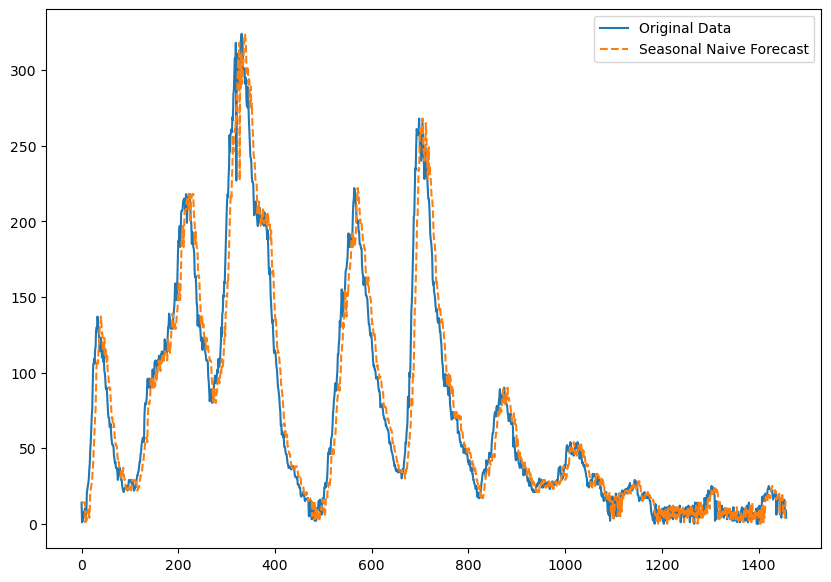

In [16]:
# seasonaly naive method

import pandas as pd
import matplotlib.pyplot as plt

# Assume 'df' is your DataFrame with the time series data
# and 'value' is the column containing the time series values
# Also assume a seasonal period (e.g., weekly, monthly)

seasonal_period = 7  # For weekly seasonality

# Create a list to store the seasonal naive forecast
seasonal_naive_forecast = []

# Loop through the test period and predict
for i in range(len(hospital_table_naive_4)):
    if i < seasonal_period:
        seasonal_naive_forecast.append(hospital_table_naive_4['respirated'].iloc[0])
    else:
        seasonal_naive_forecast.append(hospital_table_naive_4['respirated'].iloc[i - seasonal_period])

# Plot the original data and the seasonal naive forecast
plt.figure(figsize=(10, 7))
plt.plot(hospital_table_naive_4['respirated'], label='Original Data')
plt.plot(seasonal_naive_forecast, label='Seasonal Naive Forecast', linestyle='--')
plt.legend()
plt.show()

In [17]:
#pip install statsforecast

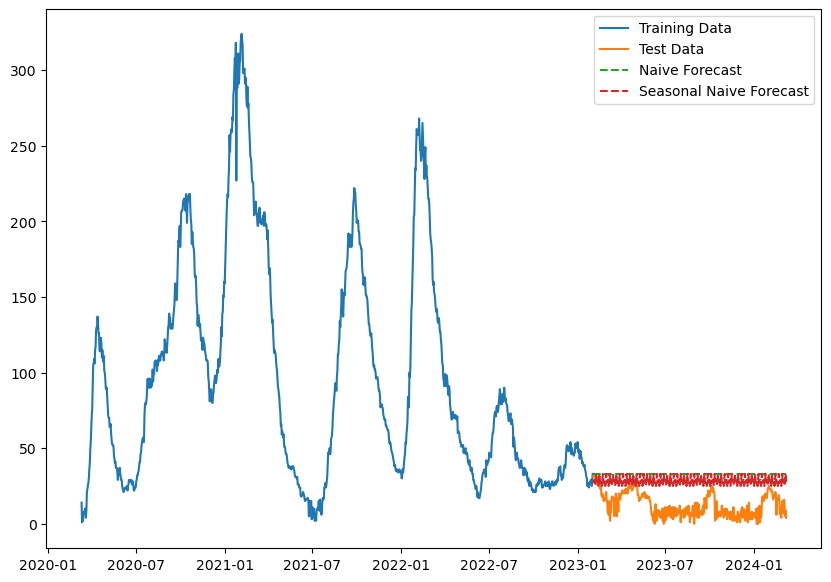

In [37]:
import pandas as pd
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive
import matplotlib.pyplot as plt

# Assume hospital_table_naive_4 is your DataFrame
# Rename the 'Date' column to 'ds' and the 'respirated' column to 'y'
hospital_table_naive_4 = hospital_table_naive_4.rename(columns={'Date': 'ds', 'respirated': 'y'})

# Ensure 'ds' is of datetime type
hospital_table_naive_4['ds'] = pd.to_datetime(hospital_table_naive_4['ds'])

# If 'unique_id' is required, add it or ensure it exists
if 'unique_id' not in hospital_table_naive_4.columns:
    hospital_table_naive_4['unique_id'] = 0  # Assign a default unique_id if not present

# Split your data into training and testing sets
train = hospital_table_naive_4[:-400]  # Example: last 30 days for testing
test = hospital_table_naive_4[-400:]

# Create a StatsForecast model
model = StatsForecast(models=[Naive(), SeasonalNaive(season_length=7)], freq='D')

# Fit the model
model.fit(train)

# Generate forecasts. Use the `num` parameter to specify the forecast horizon.
#forecasts = model.forecast(h=len(test))  # Now directly call forecast without passing train
forecasts = model.forecast(df=train, h=len(test))  # Pass both the DataFrame and the forecast horizon


# Plot the original data and the forecasts
plt.figure(figsize=(10, 7))
plt.plot(train['ds'], train['y'], label='Training Data')
plt.plot(test['ds'], test['y'], label='Test Data')
plt.plot(test['ds'], forecasts['Naive'], label='Naive Forecast', linestyle='--') # Correct this to use test['ds']
plt.plot(test['ds'], forecasts['SeasonalNaive'], label='Seasonal Naive Forecast', linestyle='--')


plt.legend()
plt.show()

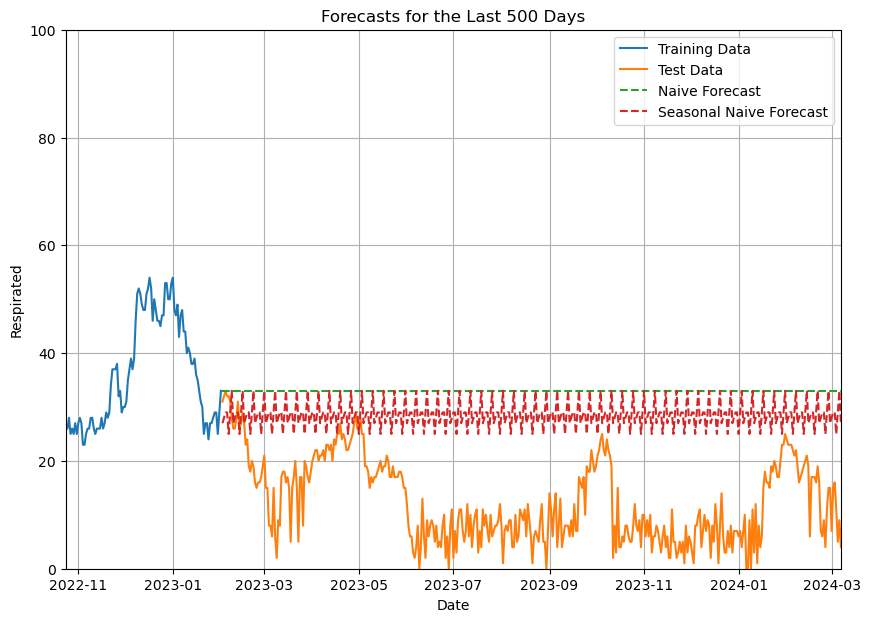

In [39]:
# now, plot just the last 500 days (or any) of the x axis

# Ensure you have the last 365 days of data for plotting
last_date = hospital_table_naive_4['ds'].max()  # Get the maximum date from your dataset
first_date = last_date - pd.Timedelta(days=500)  # Calculate the date 365 days prior to the maximum date

# Plot the original data and the forecasts
plt.figure(figsize=(10, 7))

# Plot training and test data
plt.plot(train['ds'], train['y'], label='Training Data')
plt.plot(test['ds'], test['y'], label='Test Data')
plt.plot(test['ds'], forecasts['Naive'], label='Naive Forecast', linestyle='--')
plt.plot(test['ds'], forecasts['SeasonalNaive'], label='Seasonal Naive Forecast', linestyle='--')

# Set x-axis limits to show only the last 500 days
plt.xlim(first_date, last_date)

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Respirated')
plt.legend()
plt.title('Forecasts for the Last 500 Days')
plt.grid()
plt.ylim(0, 100)  # Set the minimum to 0 and the maximum to 50
plt.show()